# Проект "Телеком"

## Описание задачи

Заказчик: Оператор связи «Ниединогоразрыва.ком».
Задача: предсказать потенциальный уход клиента.
Входные данные: представлен массив сведений об использовании клиентами услуг, как действующими, так и прекратившими обслуживание:
- информация о договорах с каждым клиентом;
- персональные данные клиента;
- информация об использовании интернет услуг;
- информация об услугах телефонии.

## План работы

Предлгается провести:
- исследовательский анализ данных;
- предобработка данных (удаление дубликатов, выбросов, заполнение пропусков, кодирование категорильных признаков, формирование выборок);
- моделирование (предлагаются модели LogisticRegression, RandomForestClassifier, CATBoost, подбор гиперпараметров средствами GridSearchCV);
- тестирование лучшей модели (на выбранных гиперпараметрах);
- вывод

## Исследовательский анализ данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: six in c:\users\danie\anaconda3\lib\site-packages (from cycler>=0.10->matplotlib>=2.2.3->phik) (1.16.0)



In [2]:
import pandas as pd
import seaborn as sns

import datetime
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from dateutil.parser import parse as du_parse
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn import preprocessing
import matplotlib.pyplot as plt

In [3]:
# фиксируем в переменной используемый в проекте random_state
rnd_st= 120922

Импортируем представленные таблицы и рассмотрим содержащиеся данные:

<B> CONTRACTS - сведения о контрактах </b>

In [4]:
contr = pd.read_csv('/datasets/final_provider/contract.csv')

In [5]:
contr.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
contr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contr['BeginDate'].value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

In [8]:
contr['EndDate'].value_counts().sort_index()

2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5174
Name: EndDate, dtype: int64

In [9]:
contr['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [10]:
contr['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [11]:
contr['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [12]:
contr['MonthlyCharges'].value_counts().sort_index()

18.25     1
18.40     1
18.55     1
18.70     2
18.75     1
         ..
118.20    1
118.35    1
118.60    2
118.65    1
118.75    1
Name: MonthlyCharges, Length: 1585, dtype: int64

In [13]:
contr['TotalCharges'].value_counts().sort_index()

          11
100.2      1
100.25     1
100.35     1
100.4      1
          ..
997.75     1
998.1      1
999.45     1
999.8      1
999.9      1
Name: TotalCharges, Length: 6531, dtype: int64

In [14]:
# для удобства обработки заменяем значение NO в сведениях об окончании обслуживания будущей датой 2021-01-01
contr.loc[contr['EndDate']=='No','EndDate']='2021-01-01'

# поле TotalCharges содержит строки с пробелом вместо значения
print(contr[contr['TotalCharges']==' '].head())

      customerID   BeginDate     EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01  2021-01-01  Two year              Yes   
753   3115-CZMZD  2020-02-01  2021-01-01  Two year               No   
936   5709-LVOEQ  2020-02-01  2021-01-01  Two year               No   
1082  4367-NUYAO  2020-02-01  2021-01-01  Two year               No   
1340  1371-DWPAZ  2020-02-01  2021-01-01  Two year               No   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05               


In [15]:
# клиенты с пробелом в поле 'TotalCharges' начали обслуживание в конце периода за который представлена информация (2020-02-01), 
# таким образом пробелы это некорректное отражение нулевой выручки по клиенту, можено заменть пробелы на 0
contr.loc[contr['TotalCharges']==' ','TotalCharges']='0'
print(contr['TotalCharges'].value_counts())

0         11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64


In [16]:
contr=contr.astype({'BeginDate':'datetime64[ns]','EndDate':'datetime64[ns]','TotalCharges':'float'})

In [17]:
contr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [18]:
contr.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2021-01-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2021-01-01,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2021-01-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [19]:
contr.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


In [20]:
contr[contr.duplicated()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [21]:
contr[contr.isna().any(axis=1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


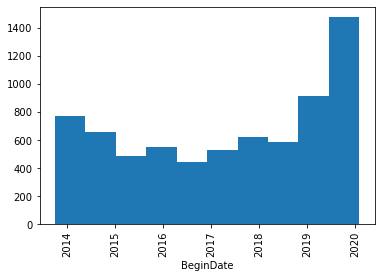

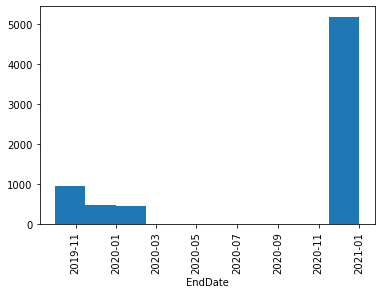

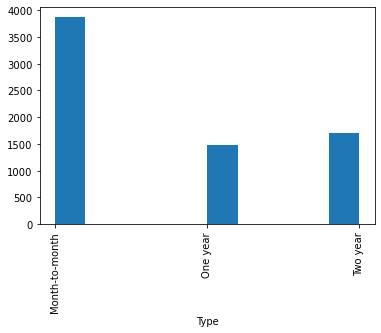

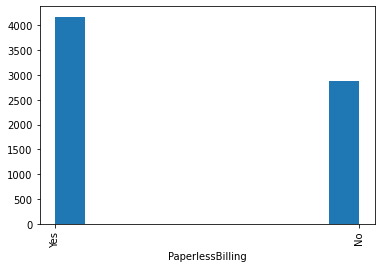

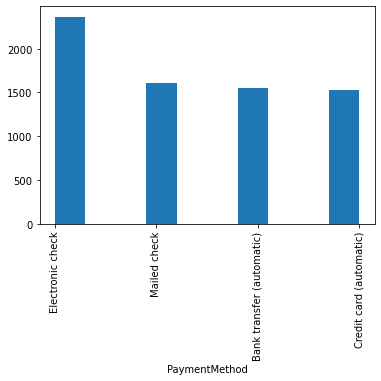

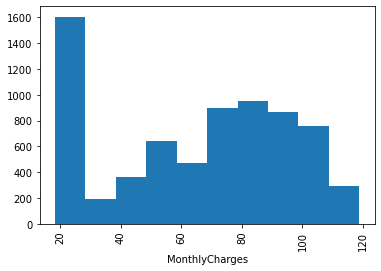

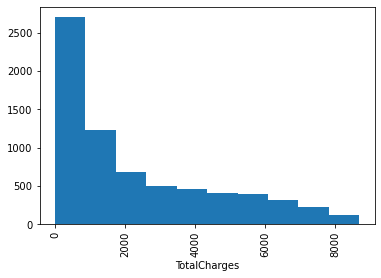

In [22]:
for _ in contr.columns[1:]:
    plt.hist(contr[_])
    plt.xlabel(_)
    plt.xticks(rotation='vertical')
    plt.show()

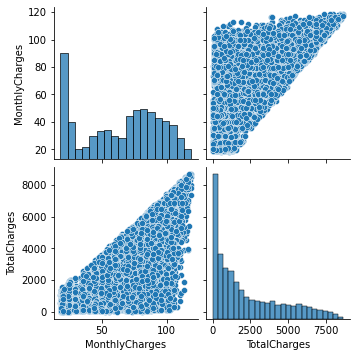

In [23]:
# проверим также наличие/отсутствие зависимостей между признаками
sns.pairplot(contr)

По таблице "Договора/Contract" устранены пропуски и приведено форматирование дат и числовых значений к соответствующему виду.

Анализ распределения показывает что:
- пик заключения договоров приходится на окончание периода за который представлена информация (возможно по таким догорам не стоит учитывать статистику)
- пик закрытия договоров приходится на окончание года, в данном случае на окончание 2019 года. таким образом возможно клиенты меняют тариф в конце года (либо в это время были интересные предложения от конкурентов но такой информации нет)
- в основном договора заключаются в "month-to-month" тарифе;
- ежемесячные сборы в основном находятся в пределах 70-110
- в целом по клиентам общие сборы находятся в пределах до 500, однако учитывая пик заключения договоров в конце оцениваемого периода данный показатель может быть сильно искажен.

<B> PERSONAL - персональные данные о клиентах </b>

In [24]:
pers = pd.read_csv('/datasets/final_provider/personal.csv')
pers.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [25]:
pers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [26]:
pers.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [27]:
pers[pers.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents


In [28]:
pers[pers.isna().any(axis=1)]

,customerID,gender,SeniorCitizen,Partner,Dependents


In [29]:
pers['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [30]:
pers['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [31]:
pers['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [32]:
pers['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

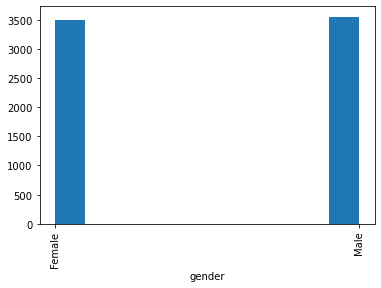

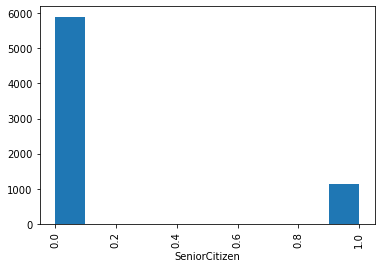

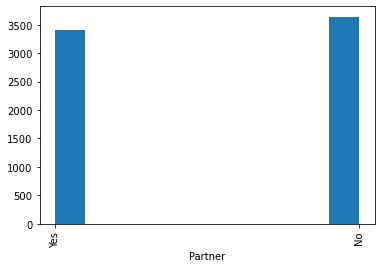

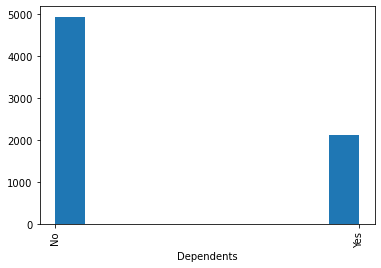

In [33]:
for _ in pers.columns[1:]:
    plt.hist(pers[_])
    plt.xlabel(_)
    plt.xticks(rotation='vertical')
    plt.show()

По таблице с персональными данными клиентов некорректных значений и/или пропусков не установлено.

Анализ распределения показывает что меньшее колиество клиентов относятся к пожилым(пенисонерам), а также к имеющим детей (иждвенцев). 

<B> INTERNET - сведения об использовании интернет услуг </b>

In [34]:
inter = pd.read_csv('/datasets/final_provider/internet.csv')
inter.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [35]:
inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [36]:
inter['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [37]:
inter.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [38]:
inter[inter.duplicated()]

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


In [39]:
inter[inter.isna().any(axis=1)]

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


In [40]:
inter['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [41]:
inter['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [42]:
inter['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [43]:
inter['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [44]:
inter['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [45]:
inter['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

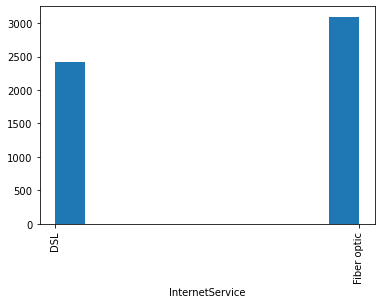

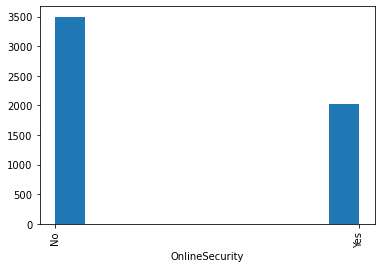

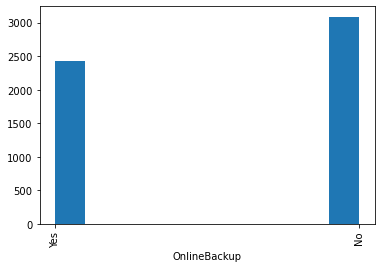

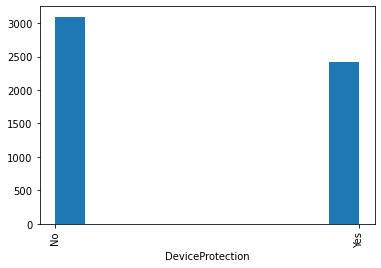

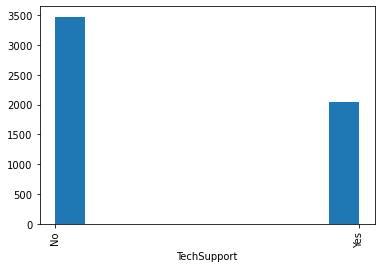

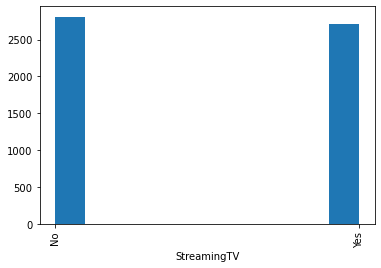

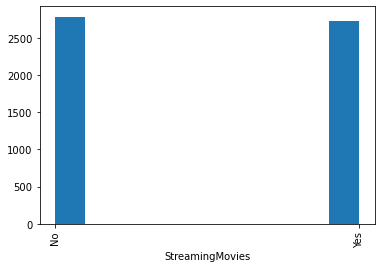

In [46]:
for _ in inter.columns[1:]:
    plt.hist(inter[_])
    plt.xlabel(_)
    plt.xticks(rotation='vertical')
    plt.show()

По таблице с данными об использовании интернета/'internet' некорректных значений и/или пропусков не установлено.

Анализ распределения показывает что в части использования техподдержки клиенты преимущественно отказываются от данной услуги.

<B> PHONE - сведения об использовании коммутационной связи </b>

In [47]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [48]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [49]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [50]:
phone[phone.duplicated()]

,customerID,MultipleLines


In [51]:
phone[phone.isna().any(axis=1)]

,customerID,MultipleLines


In [52]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

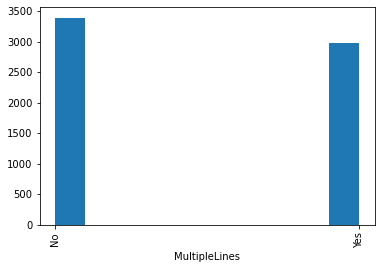

In [53]:
for _ in phone.columns[1:]:
    plt.hist(phone[_])
    plt.xlabel(_)
    plt.xticks(rotation='vertical')
    plt.show()

По таблице с данными об использовании проводной связи/phones пропусков или некорректных значений не установлено.

Анализ распределения по данной колонке существеного дисбаланса не показал.

<b> Объединение таблицы </b>

In [54]:
data = contr.merge(pers, on='customerID', how='outer')

In [55]:
data = data.merge(inter, on='customerID', how='outer')

In [56]:
data = data.merge(phone, on='customerID', how='outer')

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [58]:
data[data.isna().any(axis=1)].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2021-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
3,7795-CFOCW,2016-05-01,2021-01-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
7,6713-OKOMC,2019-04-01,2021-01-01,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
11,7469-LKBCI,2018-10-01,2021-01-01,Two year,No,Credit card (automatic),18.95,326.80,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,2015-10-01,2021-01-01,One year,No,Mailed check,20.65,1022.95,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
20,8779-QRDMV,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,39.65,39.65,Male,1,No,No,DSL,No,No,Yes,No,No,Yes,NaN
21,1680-VDCWW,2019-02-01,2021-01-01,One year,No,Bank transfer (automatic),19.80,202.25,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
22,1066-JKSGK,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
27,8665-UTDHZ,2019-11-01,2019-12-01,Month-to-month,No,Electronic check,30.20,30.20,Male,0,Yes,Yes,DSL,No,Yes,No,No,No,No,NaN
33,7310-EGVHZ,2020-01-01,2021-01-01,Month-to-month,No,Bank transfer (automatic),20.20,20.20,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


После объединения получаем определенное количество пустых значений, которые можно заполнить значением NO

In [59]:
data.loc[:,'InternetService':'MultipleLines'] = data.loc[:,'InternetService':'MultipleLines'].fillna('No')

In [60]:
data[data.isna().any(axis=1)].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [62]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2021-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,2021-01-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2021-01-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<b> Проверка коллинеарности признаков </b>

В связи с наличием преимущественно категориальных признаков применим для рассчета корелляции модуль phik предлагающий методы расчета корреляции категориальных признаков

In [63]:
phik_data = data.loc[:,'Type':]
phik_data = phik_data.drop(['MonthlyCharges','TotalCharges'],axis=1)
phik_overview = phik_data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['SeniorCitizen']


,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
Type,1.00,0.11,0.28,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07
PaperlessBilling,0.11,1.00,0.37,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
PaymentMethod,0.28,0.37,1.00,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34
gender,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.09,0.24,0.29,0.00,1.00,0.02,0.32,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.22
Partner,0.18,0.01,0.24,0.00,0.02,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22
Dependents,0.15,0.17,0.22,0.00,0.32,0.65,1.00,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.03
InternetService,0.51,0.23,0.32,0.00,0.16,0.00,0.11,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.23
OnlineSecurity,0.15,0.00,0.26,0.02,0.06,0.22,0.12,0.24,1.00,0.43,0.42,0.53,0.27,0.29,0.15
OnlineBackup,0.10,0.20,0.28,0.01,0.10,0.22,0.03,0.23,0.43,1.00,0.46,0.45,0.43,0.42,0.31


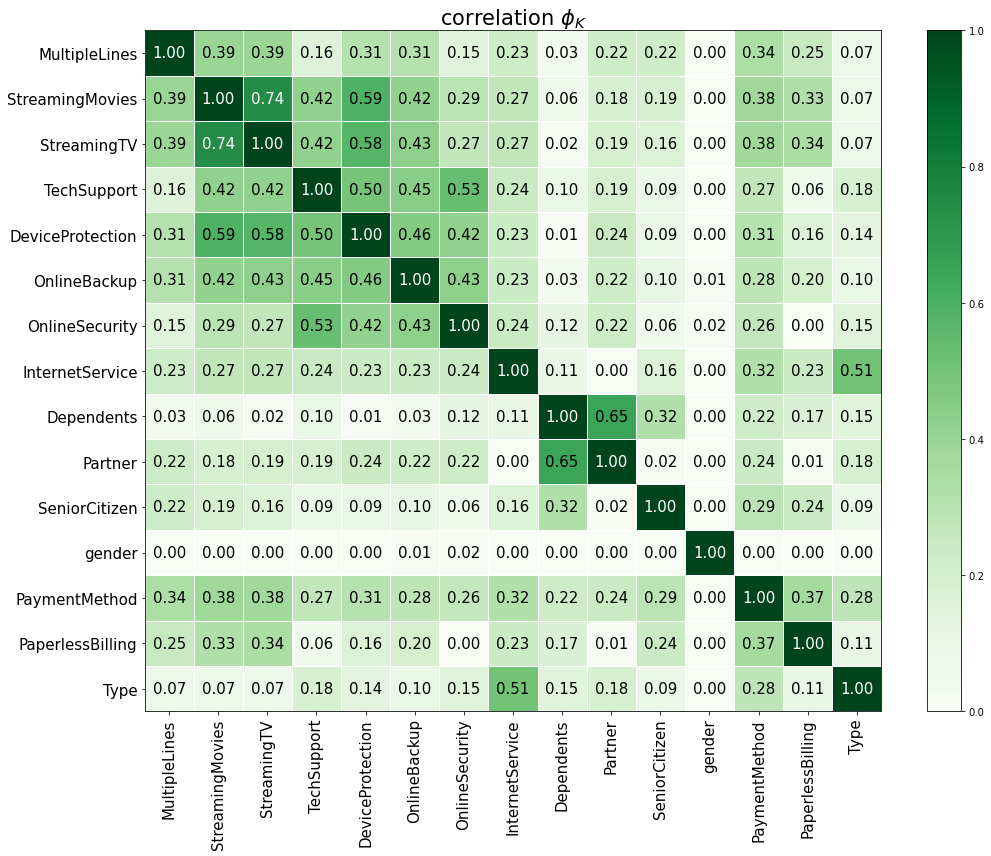

In [64]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 12))
plt.tight_layout()

<div class='alert alert-success'> 👍

interval columns not set, guessing: ['SeniorCitizen']


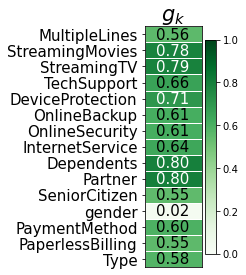

In [65]:
global_correlation, global_labels = phik_data.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

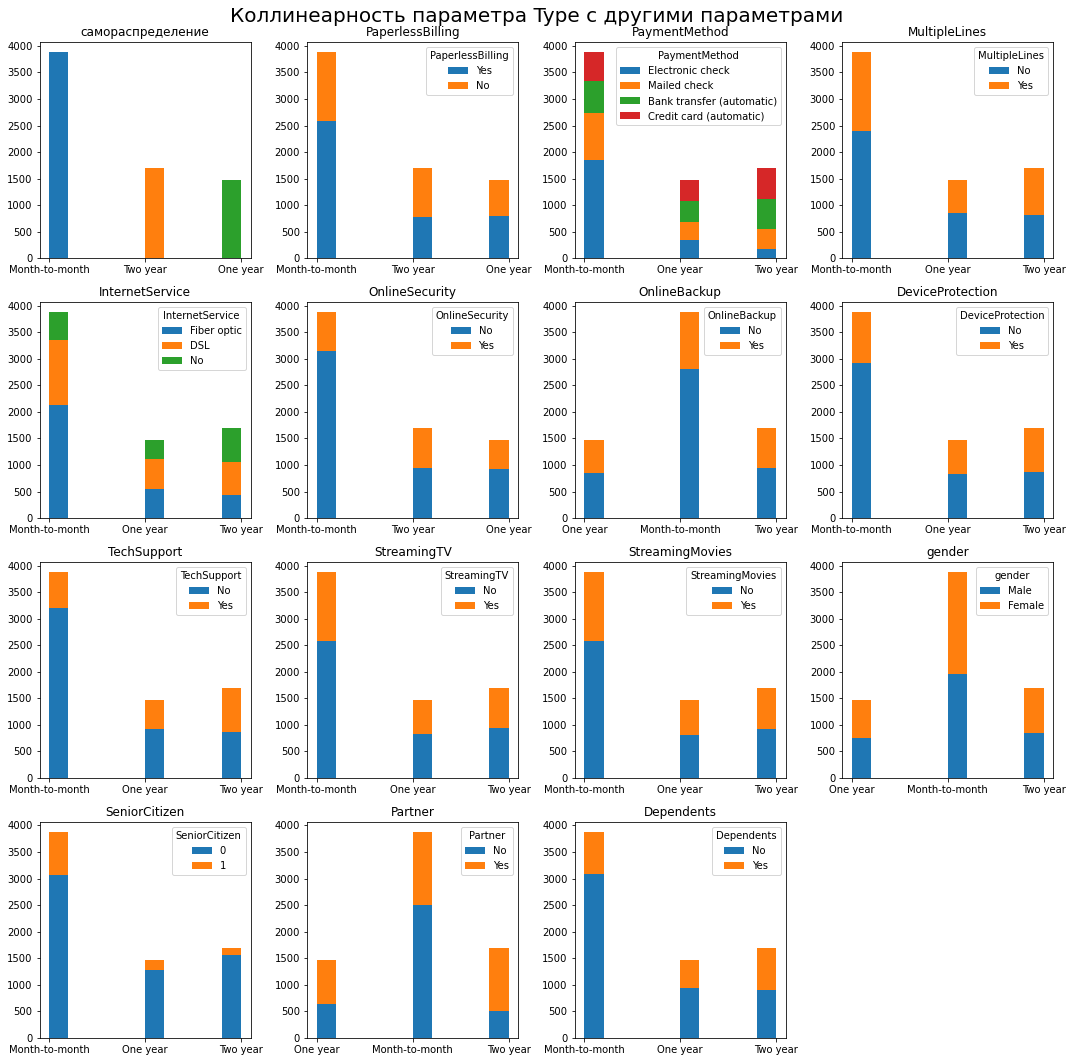

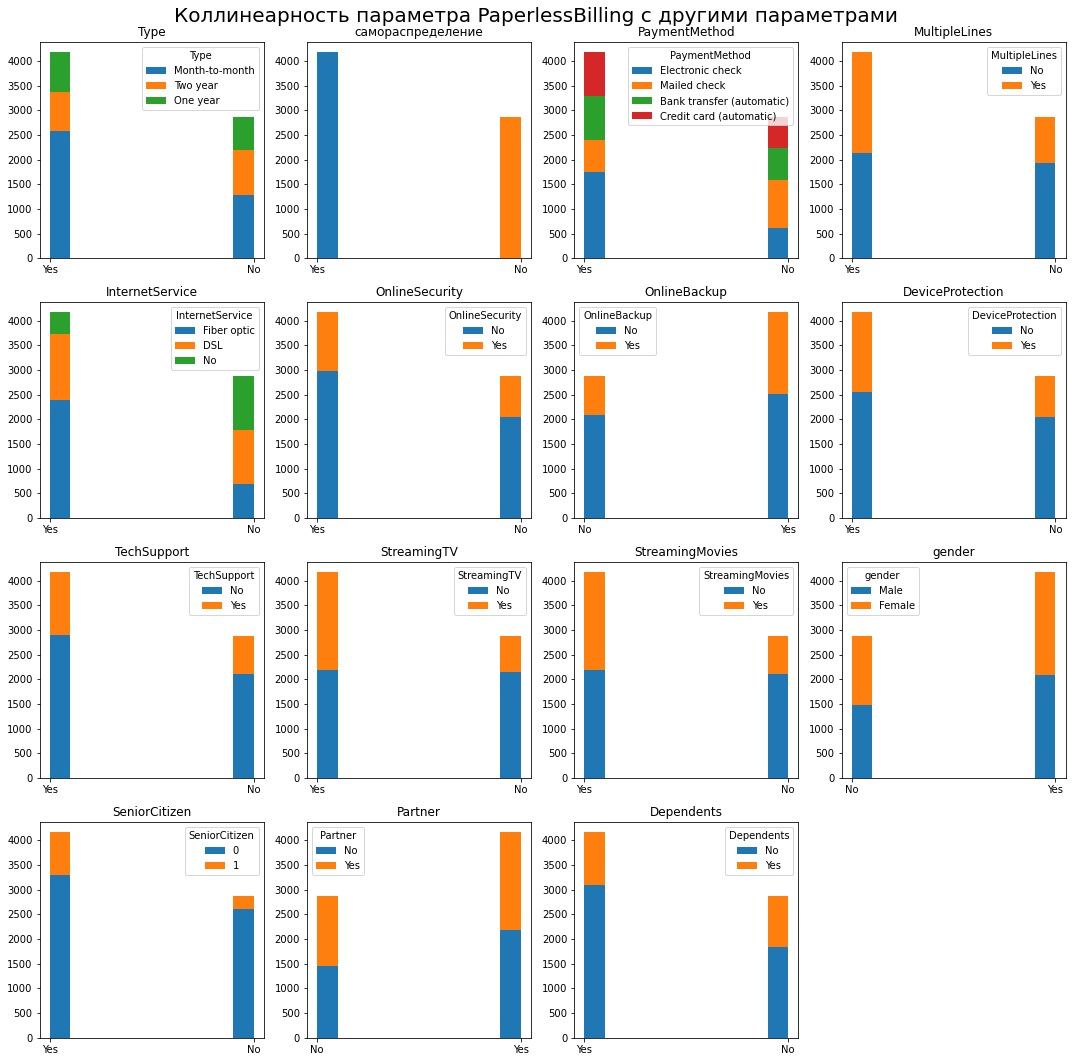

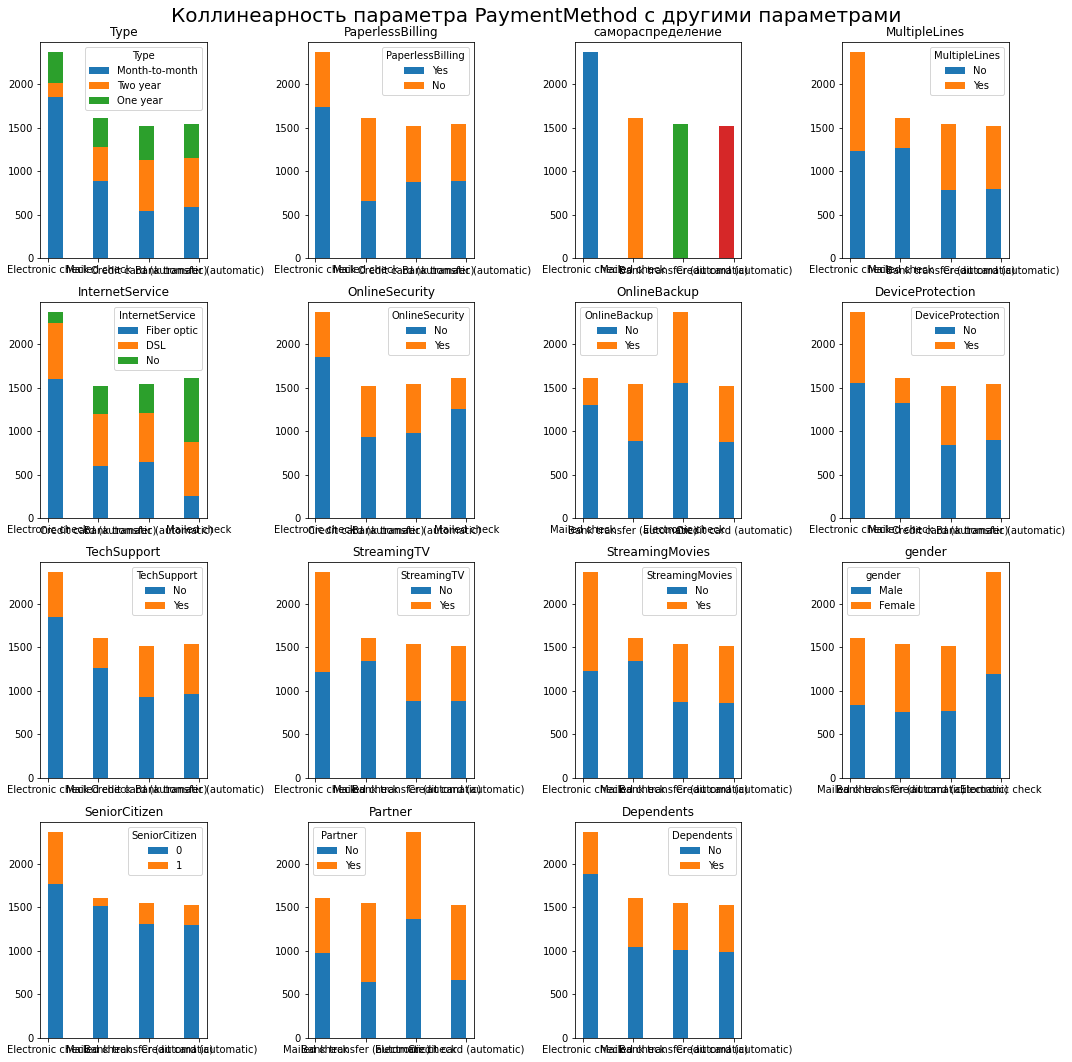

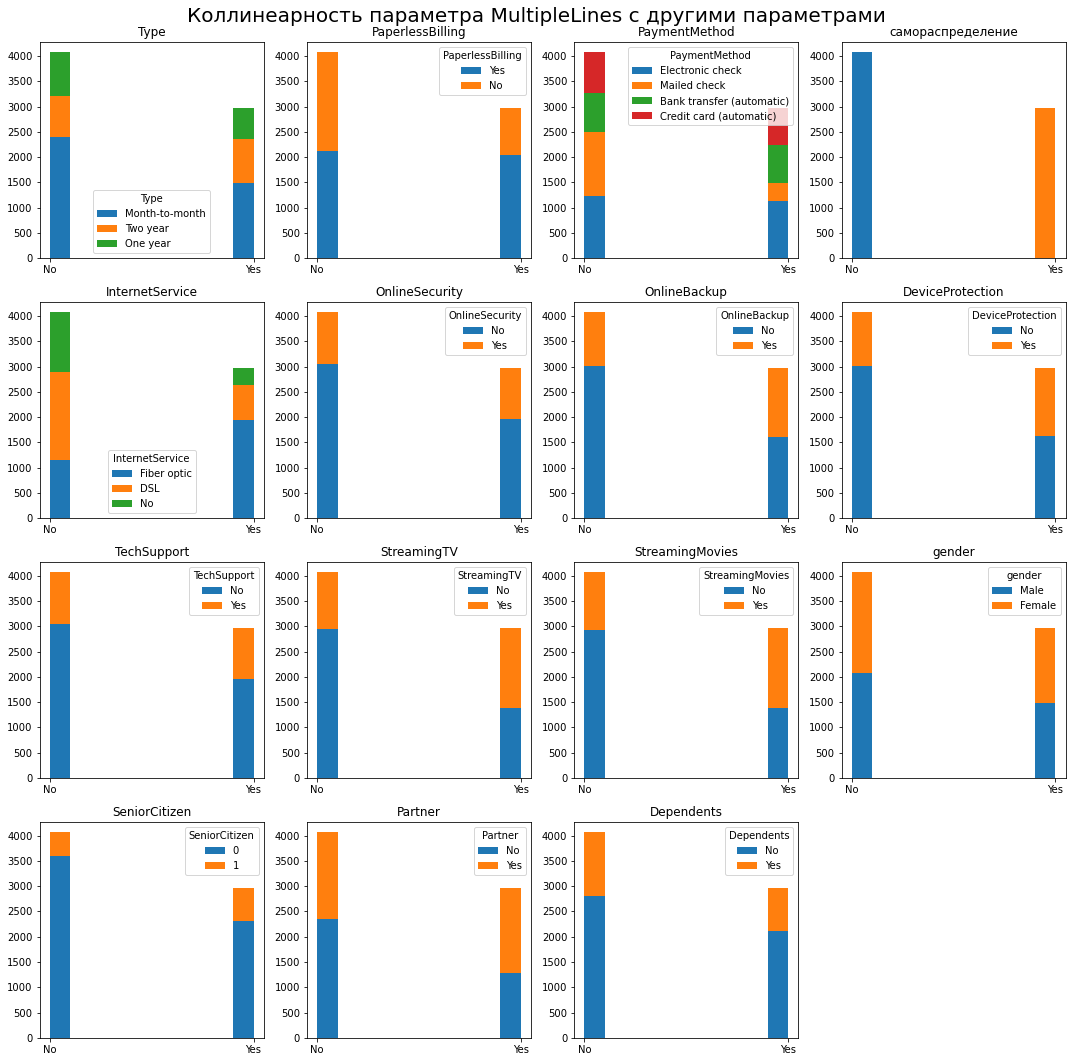

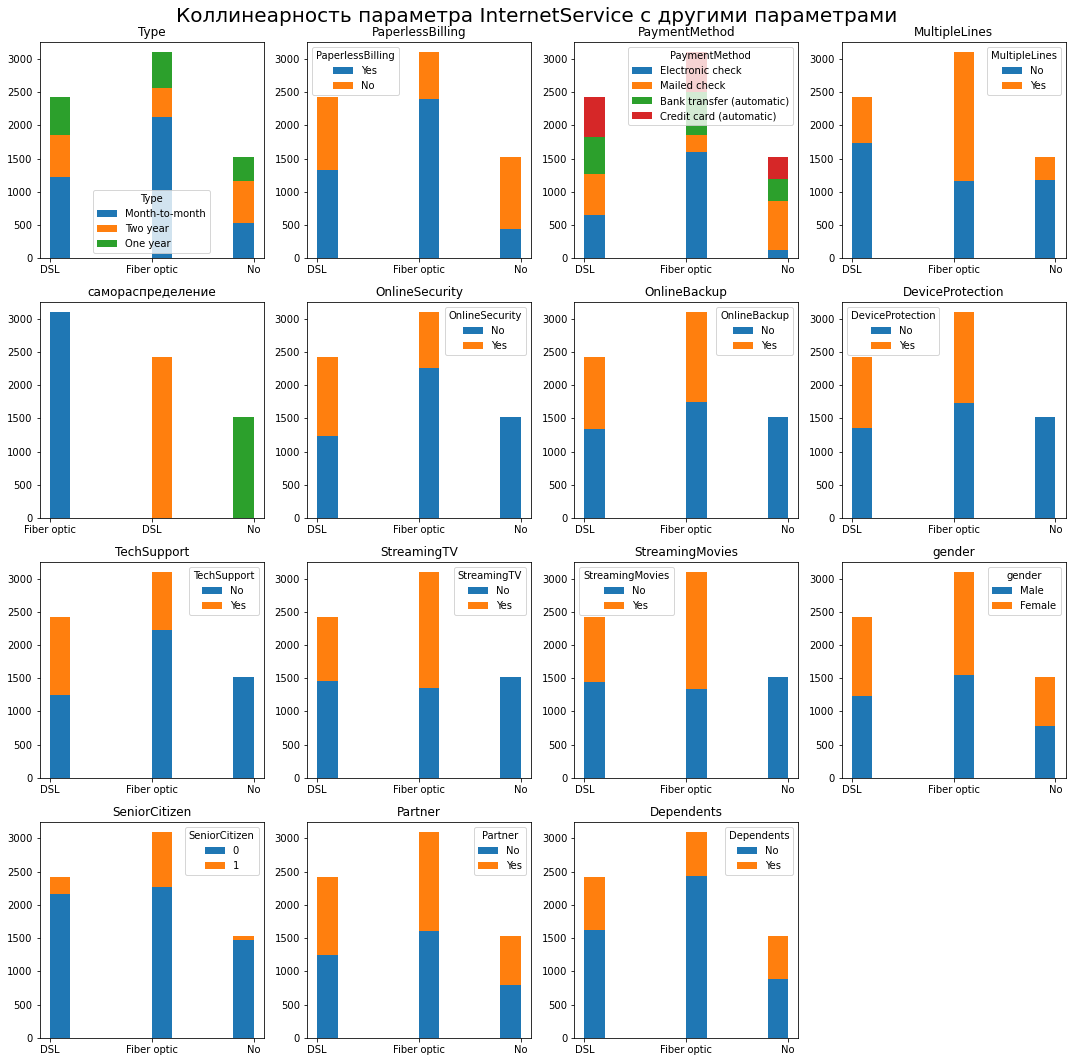

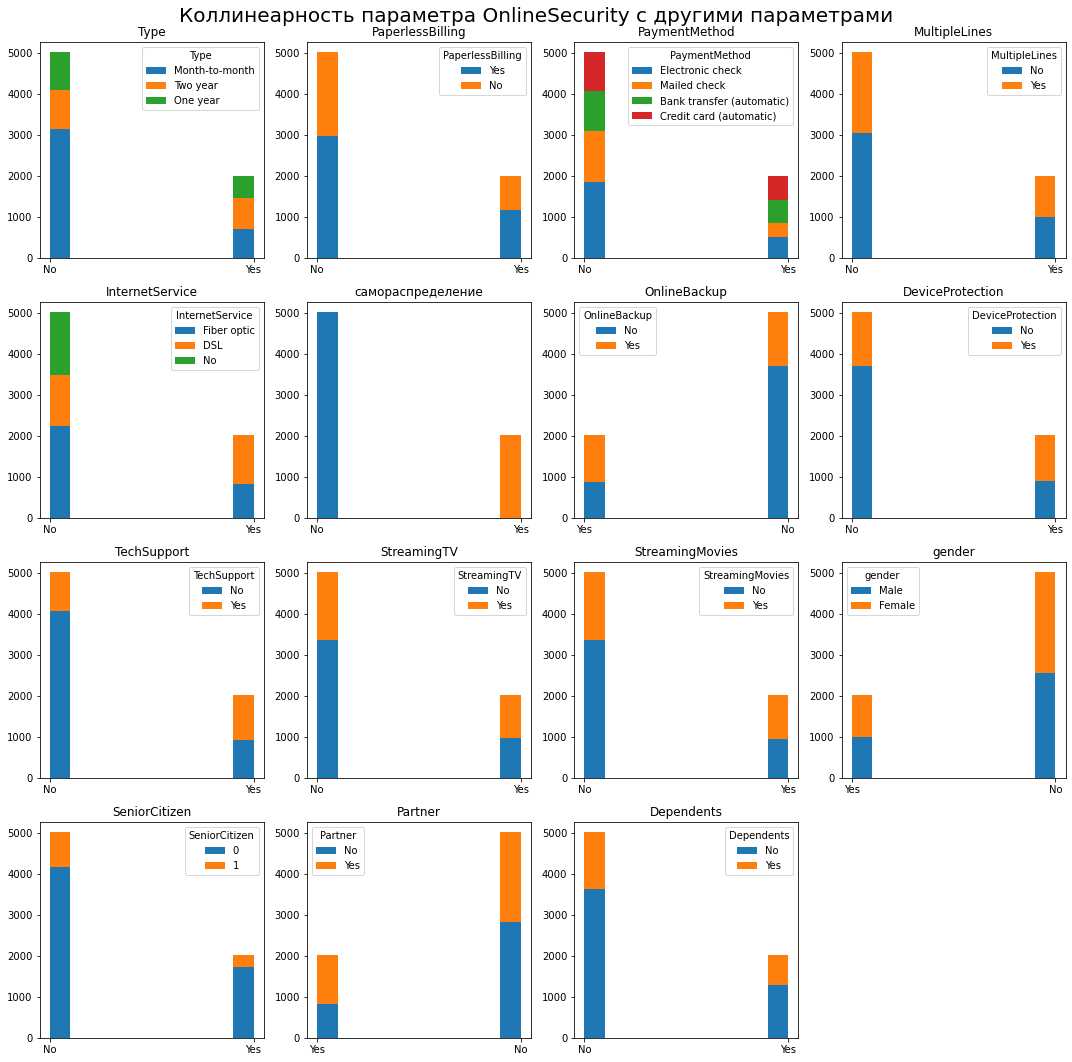

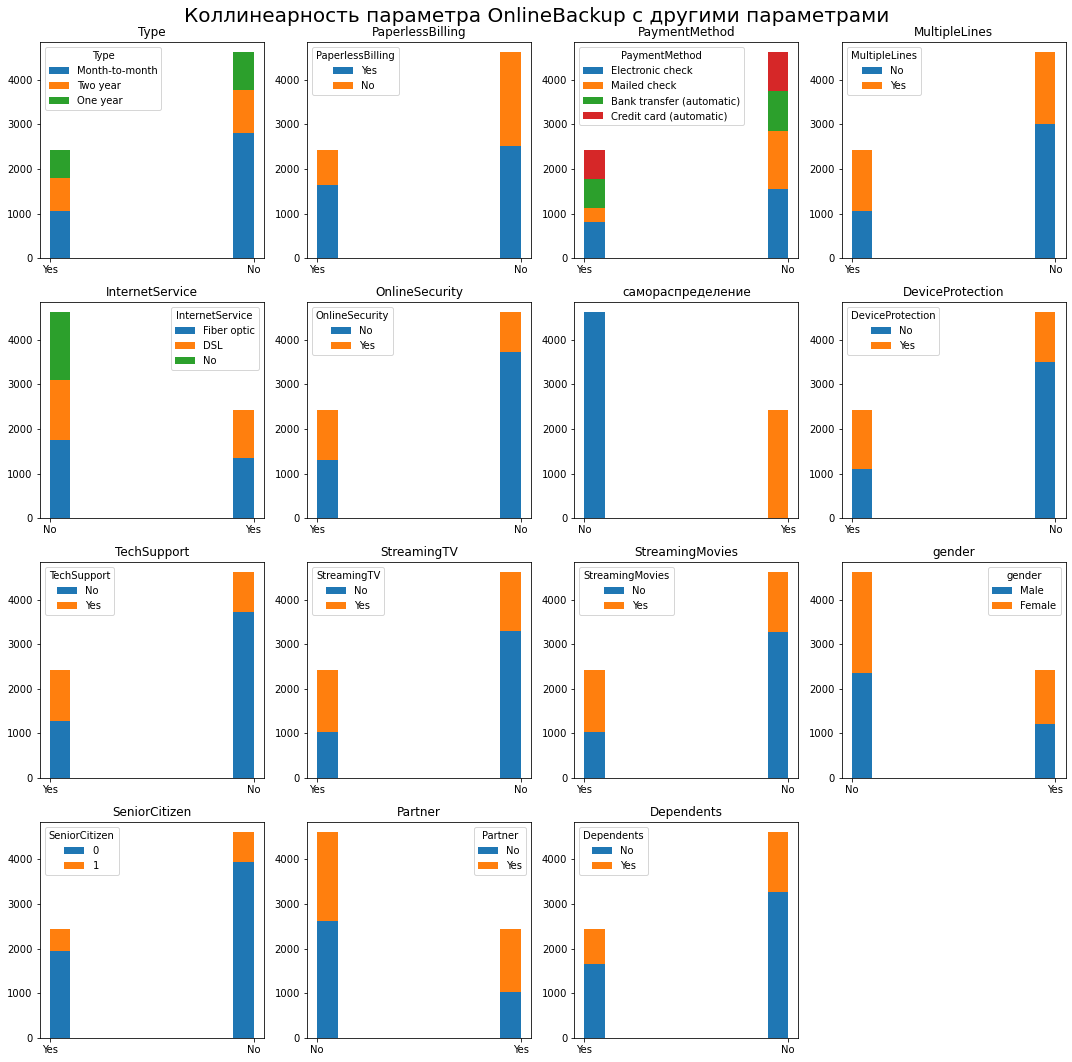

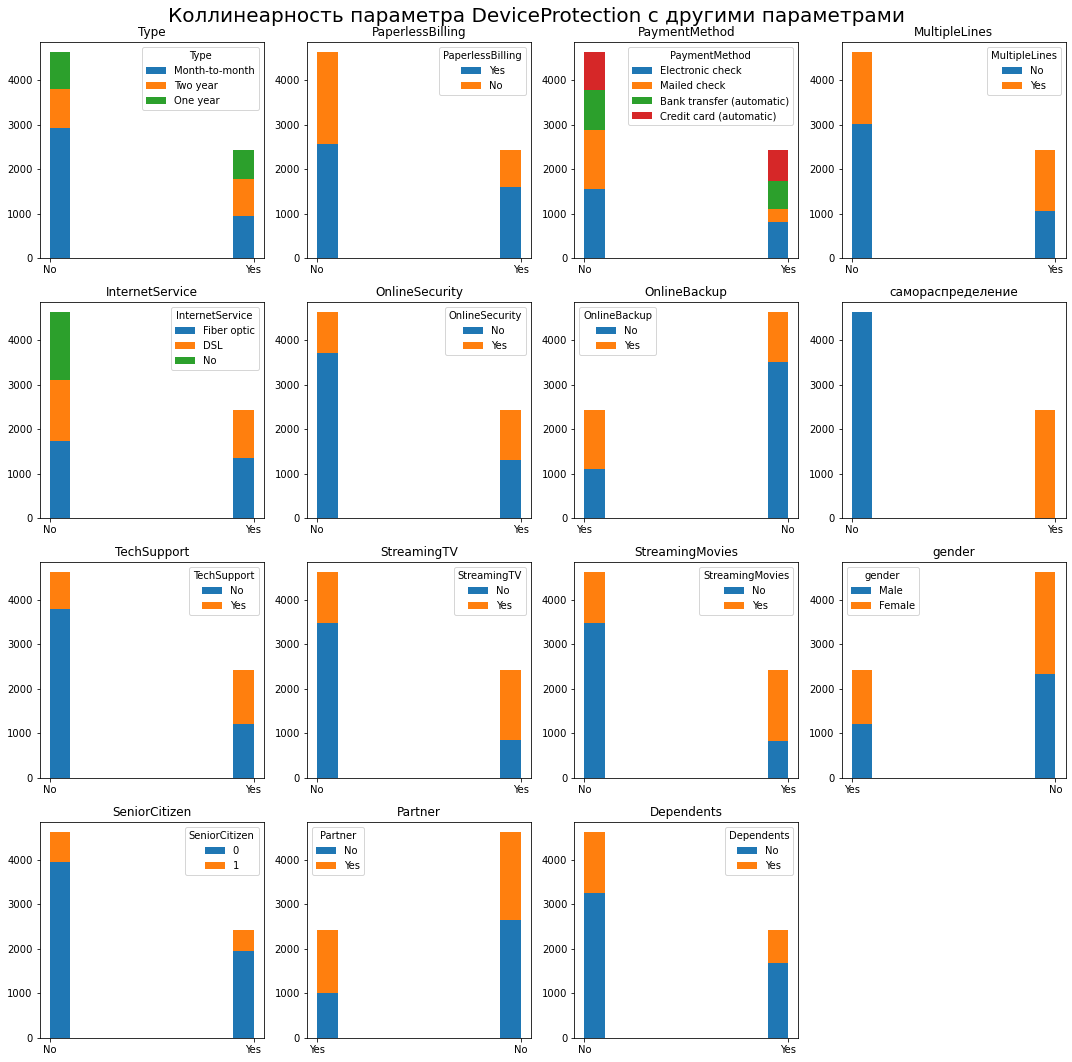

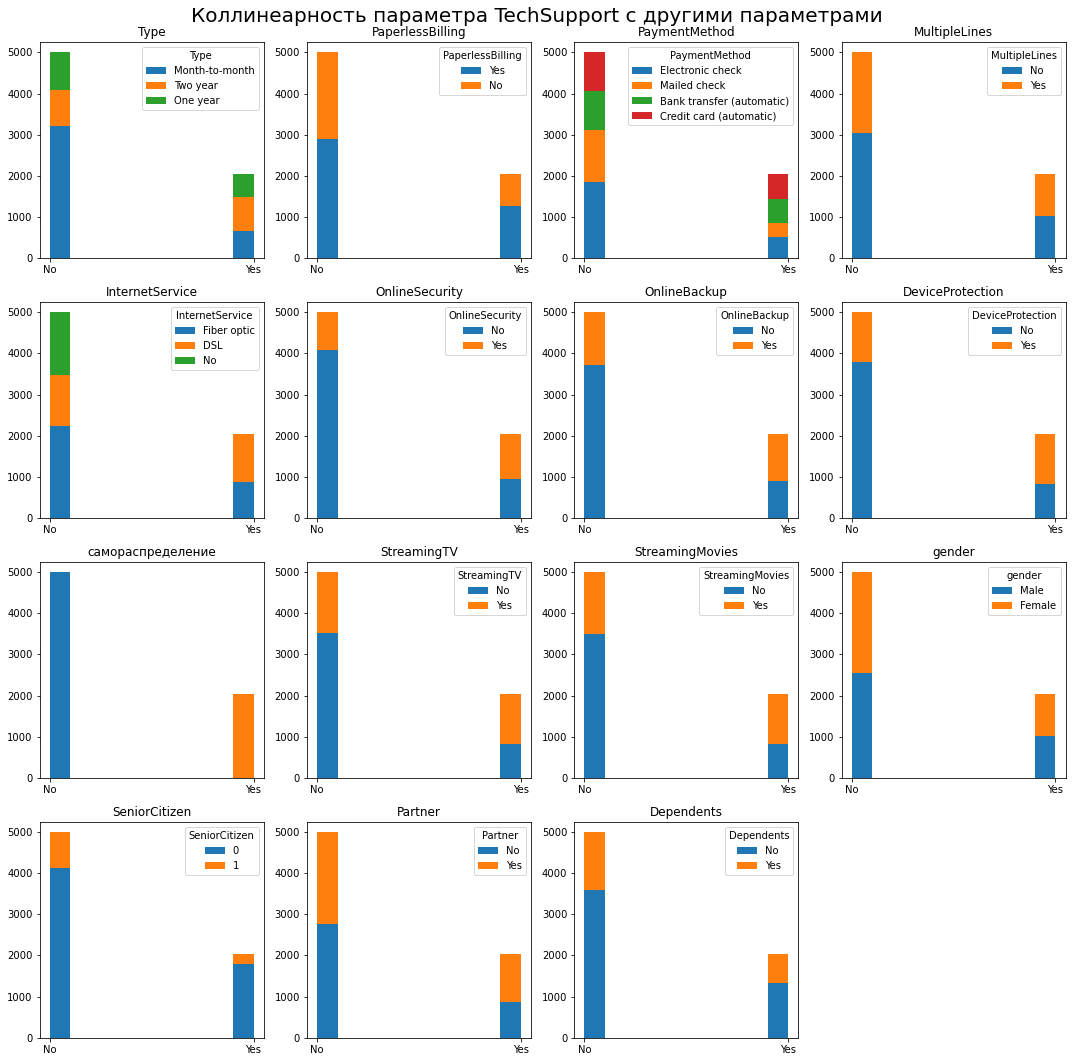

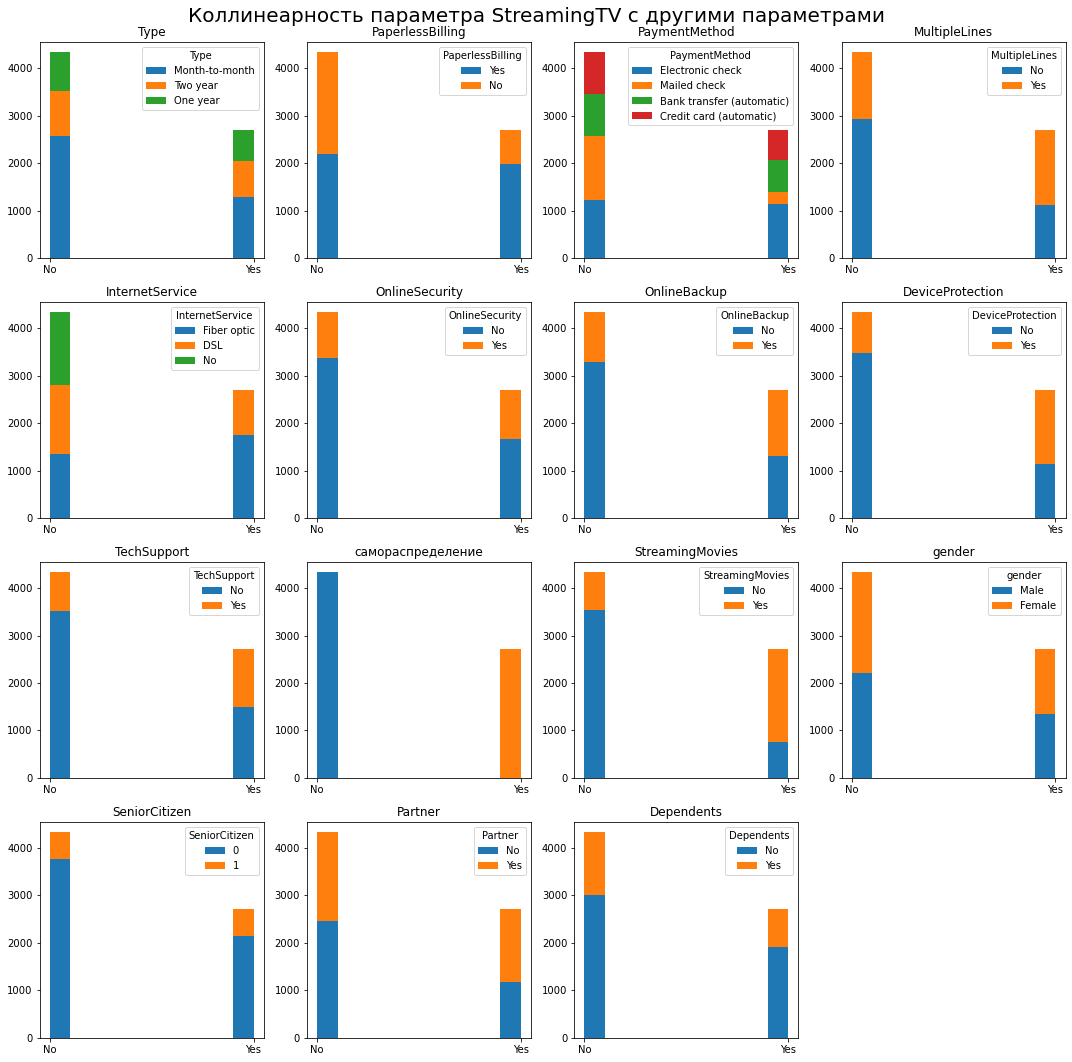

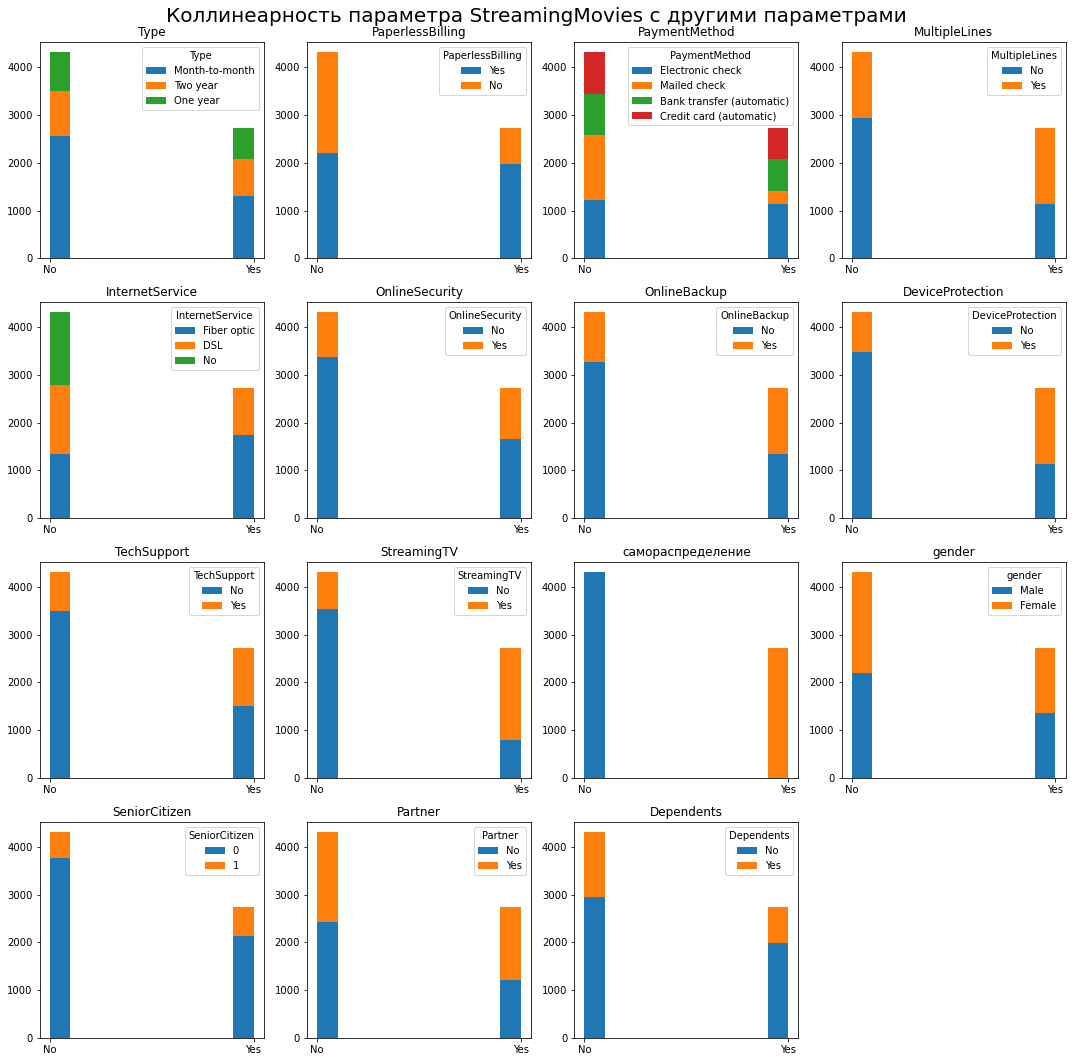

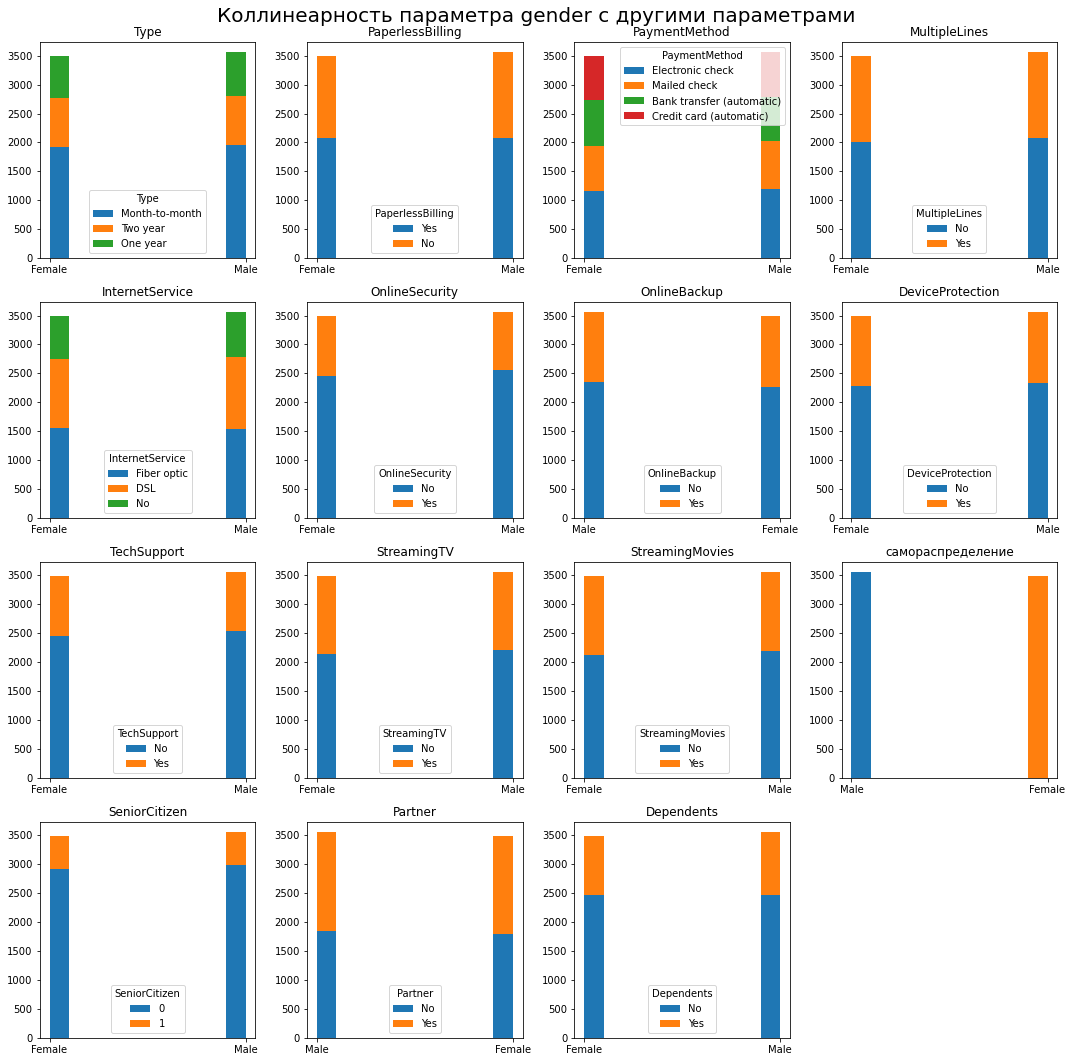

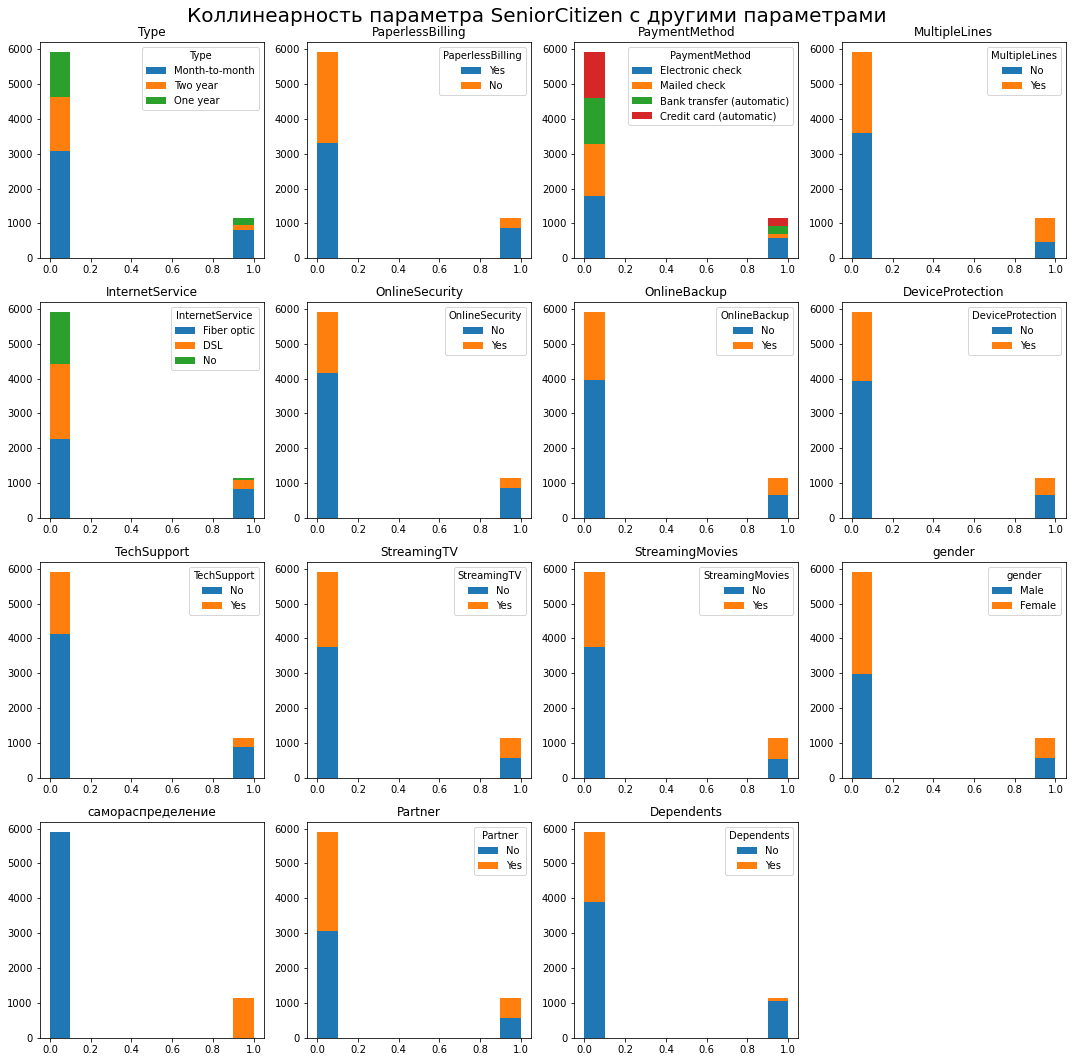

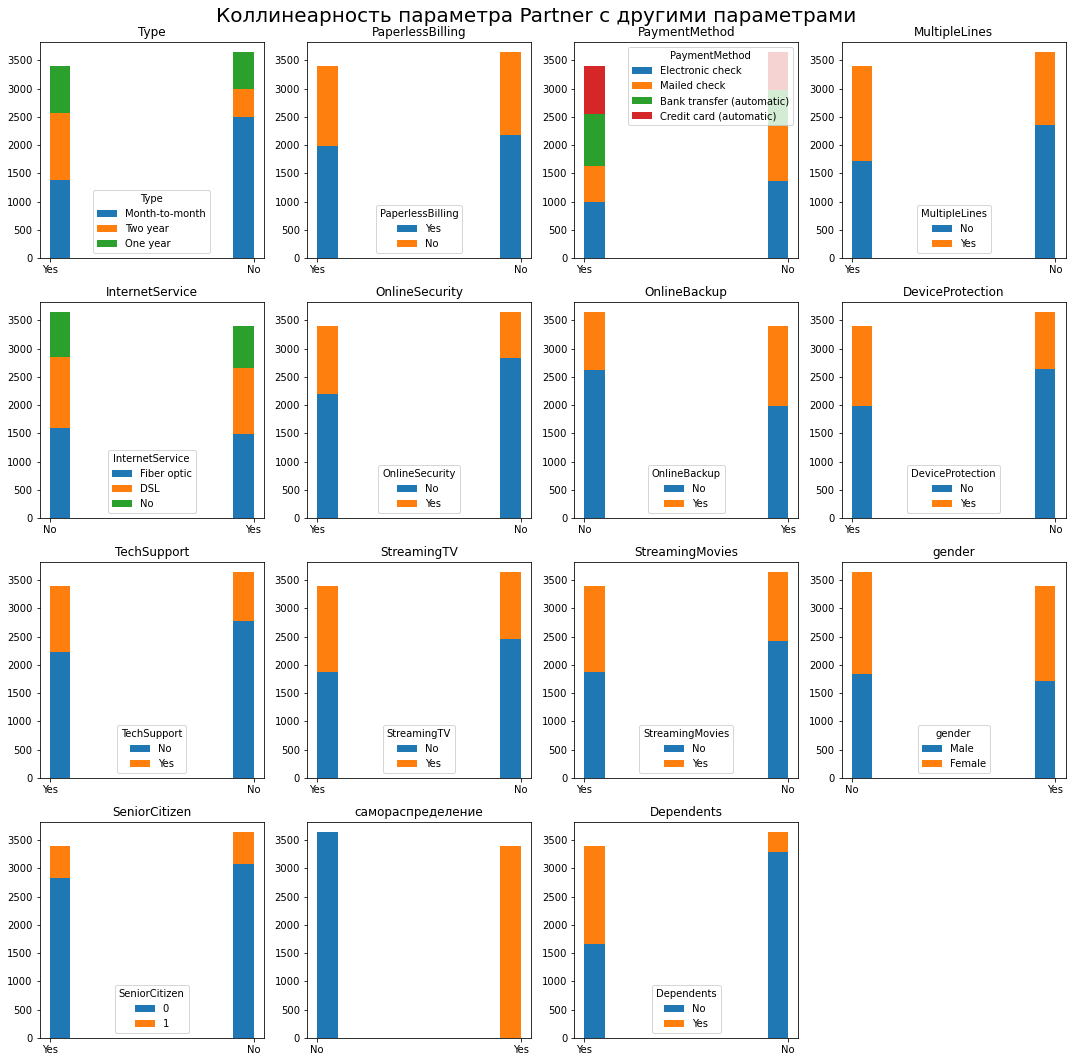

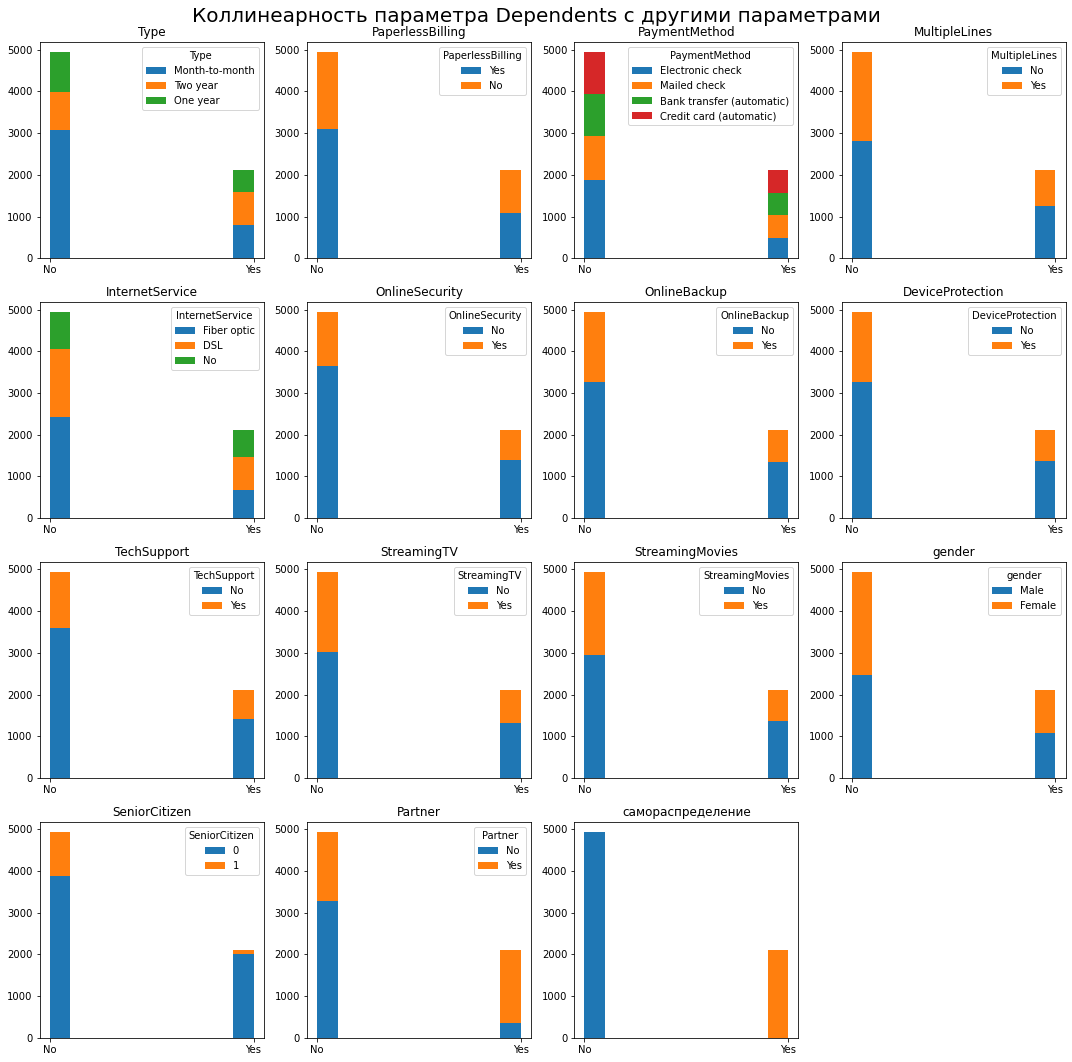

In [66]:
# выведем графически взаимное распределение признаков

# создаем два вложенных цикла - сопоставляем столбцы между собой для получения наглядного представления о наличии кллинеарности
# поскольку доступный меанизм например seaborn.pairplot категориальные признаки не показывает

column_list=['Type', 'PaperlessBilling', 'PaymentMethod', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']

for col_ in column_list:

    fig = plt.figure(figsize=(15,15))
    fig.suptitle('Коллинеарность параметра '+col_ +' с другими параметрами', fontsize = 20)
    for _ in range(0,len(column_list)):
        row_=column_list[_]
        counter = list(data[row_].value_counts().index)
        pd_er=[]
        #print(row_)
        for val_ in counter:
            pd_er.append(data.loc[data[row_]==val_,col_])
        df_er = pd.DataFrame(pd_er, columns=counter)
        fig.add_subplot(4,4,_+1)
        #plt.figure(figsize=(5,5))
        if row_==col_:
            plt.title('самораспределение')
            plt.hist(pd_er, histtype = 'barstacked',stacked=True)
        else:
            plt.title(row_)# + ' по соответствующим параметрам ' +col_ )
            plt.hist(pd_er, histtype = 'barstacked',stacked=True)
            plt.legend(counter, title=row_)
            #plt.xlabel(col_)
            plt.tight_layout()
    plt.show()

### Вывод по анализу данных:

В представленных клиентам данных в целом поля заполнены полностью. Имеются отдельные пропуски связанные с указанием пробелов вместо "0", устраненные в ходе анализа данных.
Данные содержат значительное количество категориальных признаков, требующих кодирования.
При этом анализ распределения признаков показал что имеет место преимущественный уход клиентов в канун рождества, а также режим оплаты за услуги связи "помесчячный".

Анализ корреляции признаков на основе коэффициентов корреляции, графиков распределения можно сделать вывод о высокой корелляциия признаков:

Dependents от фактора SeniorCitizen  и Partner, при этом остальные признаки распределены относительно Dependents равномерно. Соответственно данный признак целесообразно при рассчетах не учитывать.
Также существенно повторяют друг друга такие параметры как StreamingTV и StreamingMovies, предлагается оставить только один StreamingTV, т.к. в противном случае мы получаем дублирующийся признак.

## Предобработка данных

В рамках сследовательского анализа установлено отсутствие пропусков данных, по ряду договоров отсутствующие категориальные признаки заполнены значением NO ввиду отсутствия у клиента услуг с такими параметрами. 


При этом отмечено наличие клиентов заключивших договор в конце периода за который представлена информация (по 1 февраля 2020).
Проверим наличие ушедших клиентов среди заключивших договор в январе 2020 года:


In [67]:
print('Всего клиентов заключивших договор в 2020 году', data[data['BeginDate']>='2020-01-01']['EndDate'].count())
data[(data['BeginDate']>'2020-01-01')&(data['EndDate']<'2021-01-01')]

Всего клиентов заключивших договор в 2020 году 244


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Предлагается исключить таких клиентов чтобы они не искажали статистику.

In [69]:
data = data[data['BeginDate']<'2020-01-01']

Также были установлена мультиколлинеарность и целесообразность исключения столбцов Dependents, StramingMovies. Также целесообразно обрать TotalCharges как производное от MonthglyCharges и срока обслуживания. Также уберем столбец CustomerID не являющийся признаком


In [70]:
data=data.drop(['Dependents','StreamingMovies','TotalCharges','customerID'],axis=1)

Даты заключения/расторжения договора целесообразно исключить, заменив на срок обслуживания в месяцах. По клиентам оставшимся на обслуживании срок обслуживания будет рассчитан до конца периода наблюдения - 2020-02-01

In [71]:
#сохраним признак окончания договора в целевой признак
data['target'] = (data['EndDate']=='2021-01-01')*1
data['target'].value_counts(normalize=True)

1    0.725107
0    0.274893
Name: target, dtype: float64

In [72]:
data.loc[data['EndDate']=='2021-01-01','EndDate']='2020-02-01'
data['ServicePeriod'] = (data['EndDate']-data['BeginDate']).dt.days/30

In [73]:
data[data.ServicePeriod==0].head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,MultipleLines,target,ServicePeriod


Осуществим подготовку выборок для разных моделей, поскольку метод кодирования зависит от применяемой в дальнейшем модели машинного обучения:

Имеет место дисбаланс классов. По учебной выборке придется устранить дисбаланс.

Даты заключения/прекращения договора более не требуются

In [74]:
data = data.drop(['BeginDate','EndDate'],axis=1)

In [75]:
data_train, data_test = train_test_split(data, test_size=0.2,random_state=rnd_st)

In [76]:
print(data_train['target'].value_counts())
data_train_0 = data_train[data_train.target==0]
data_train_1 = data_train[data_train.target==1]
if len(data_train_0)>len(data_train_1):
    data_train_1 = resample(data_train_1, replace=True, n_samples=len(data_train_0), random_state=rnd_st)
elif len(data_train_0)<len(data_train_1):
    data_train_0 = resample(data_train_0, replace=True, n_samples=len(data_train_1), random_state=rnd_st)
data_train_balanced = pd.concat([data_train_0, data_train_1])
data_train_balanced['target'].value_counts()

1    3956
0    1483
Name: target, dtype: int64


0    3956
1    3956
Name: target, dtype: int64

In [77]:
data_train_balanced.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,MultipleLines,target,ServicePeriod
6030,Month-to-month,Yes,Bank transfer (automatic),49.05,Female,0,No,DSL,No,No,Yes,No,Yes,No,0,43.633333
4269,Month-to-month,No,Credit card (automatic),90.20,Male,0,Yes,Fiber optic,Yes,Yes,Yes,No,No,Yes,0,17.266667
3350,Month-to-month,Yes,Mailed check,44.15,Male,0,No,DSL,No,No,No,No,No,No,0,1.033333
6945,Two year,No,Bank transfer (automatic),98.30,Male,0,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,0,71.066667
5390,Month-to-month,Yes,Electronic check,99.45,Male,1,No,Fiber optic,No,No,Yes,No,Yes,Yes,0,12.166667


In [78]:
#выделим целевой признак для исходной учебной выборки
target_train = data_train.target
features_train = data_train.drop('target',axis=1)

#выделим целевой признак для сбалансированного учебного массива
target_train_balanced = data_train_balanced.target
features_train_balanced = data_train_balanced.drop('target', axis=1)

#выделим целевой признак для тестовой выборки (не применялось выравнивание дисбаланса)
target_test = data_test.target
features_test = data_test.drop('target',axis=1)

In [79]:
#определим столбцы для категорирования
categories = ['Type','PaperlessBilling','PaymentMethod','gender','SeniorCitizen','Partner','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','MultipleLines']

In [80]:
# проведем кодирование категориальных признаков для обучения линейной регрессии

features_train_ohe = features_train_balanced.copy()
enc = preprocessing.OneHotEncoder(drop='first').fit(features_train_ohe[categories])

features_train_ohe = pd.DataFrame(enc.transform(features_train_ohe[categories]).toarray(),columns=enc.get_feature_names(),index=features_train_balanced.index)

features_train_ohe= pd.concat([features_train_ohe,features_train_balanced.drop(categories,axis=1)],axis=1)

features_test_ohe = features_test.copy()

features_test_ohe = pd.DataFrame(enc.transform(features_test_ohe[categories]).toarray(),columns=enc.get_feature_names())
features_test_ohe = pd.concat([features_test_ohe,features_test.drop(categories,axis=1)],axis=1)

In [81]:
#случайного леса
category_encoder = OrdinalEncoder()
features_train_oe = features_train_balanced.copy()

category_encoder.fit(features_train_oe[categories])
features_train_oe[categories] = category_encoder.transform(features_train_oe[categories])

features_test_oe = features_test.copy()
features_test_oe[categories] = category_encoder.transform(features_test_oe[categories])

## Моделирование

In [83]:
# Сложим результаты в таблицу для наглядного представления
metrics = pd.DataFrame(columns = ['model_name','roc_auc'])

In [84]:
#Логистическая регрессия
model_regre = LogisticRegression(random_state=rnd_st)
parameters = {'fit_intercept':[True,False],'solver':['lbfgs','liblinear'], 'max_iter':[500,1000,2000]}
searcher = GridSearchCV(model_regre, parameters, cv=3, scoring='roc_auc', verbose=5, n_jobs=3)
searcher.fit(features_train_ohe, target_train_balanced)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=120922), n_jobs=3,
             param_grid={'fit_intercept': [True, False],
                         'max_iter': [500, 1000, 2000],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=5)

In [85]:

print("Наилучший результат для модели логистической регрессии ROC-AUC-", searcher.best_score_)
print('Наилучшие параметры для модели логистической -', searcher.best_params_)

Наилучший результат для модели логистической регрессии ROC-AUC- 0.8434661997481903
Наилучшие параметры для модели логистической - {'fit_intercept': True, 'max_iter': 500, 'solver': 'liblinear'}


In [86]:
#Случайный лес
# n_estimators менее 100 неактуально, возьмем от 200 и до 500 деревьев
# max_depth при 14 признаках более 14 будет приводить к переобучению. Менее 7 не имеет смысла, т.к. признаки не будут рассмотрены.

model_forest = RandomForestClassifier(random_state=rnd_st)
parameters_forest = {'n_estimators': range(200, 501, 50),
                 'max_depth': range(7,15)}
searcher_forest = GridSearchCV(model_forest, parameters_forest,
                         cv=5, verbose=5, scoring='roc_auc',n_jobs=3)

searcher_forest.fit(features_train_oe, target_train_balanced)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=120922),
             n_jobs=3,
             param_grid={'max_depth': range(7, 15),
                         'n_estimators': range(200, 501, 50)},
             scoring='roc_auc', verbose=5)

In [87]:
print("Наилучший результат для модели случайного леса ROC-AUC-", searcher_forest.best_score_)
print("Наилучшие параметры для модели случайного леса -", searcher_forest.best_params_)

Наилучший результат для модели случайного леса ROC-AUC- 0.9741851177946408
Наилучшие параметры для модели случайного леса - {'max_depth': 14, 'n_estimators': 450}


In [88]:
#обучим модель CatBoost категориальные признаки для данной модели не нужно преобразовывать достаточно передать перечень
model_cat = CatBoostClassifier(random_state=rnd_st, silent=True,cat_features=categories)
#model_cat.fit(features_train_cat, target_train_cat,verbose=5)
parameters_cat = {'learning_rate': [0.05,0.3, 0.5, 0.8],
        'iterations': [50, 150, 500]}

searcher_cat = GridSearchCV(model_cat, parameters_cat,
                         cv=5, verbose=5, scoring='roc_auc', n_jobs=3)

searcher_cat.fit(features_train, target_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000013022A26700>,
             n_jobs=3,
             param_grid={'iterations': [50, 150, 500],
                         'learning_rate': [0.05, 0.3, 0.5, 0.8]},
             scoring='roc_auc', verbose=5)

In [89]:
print("Наилучший результат для модели CatBOOST ROC-AUC-", searcher_cat.best_score_)
print("Наилучшие параметры для модели CatBOOST -", searcher_cat.best_params_)

Наилучший результат для модели CatBOOST ROC-AUC- 0.9206376099766587
Наилучшие параметры для модели CatBOOST - {'iterations': 500, 'learning_rate': 0.3}


<b> Вывод</b>

Наилучшие результаты показала модель Случайный лес, с результатом roc_auc = 0.97 при установленном заданием пороге в 0.85

## Тестирование лучшей модели

In [90]:
best_model = RandomForestClassifier(random_state=rnd_st, max_depth=14, n_estimators=450)
best_model.fit(features_train_oe,target_train_balanced)
predictions_proba = best_model.predict_proba(features_test_oe)
print('ROC-AUC : {:.2f}'.format(roc_auc_score(target_test,
                                              predictions_proba[:,1])))


ROC-AUC : 0.88


In [91]:
predictions = best_model.predict(features_test_oe)
print('Accuracy : {:.2%}'.format(accuracy_score(target_test,
                                                predictions)))

Accuracy : 81.32%


## Отчет

Для выполнения задачи проведены работы в соответствии с планом. План выполнен в полном объеме, корректировка не потребовалась:

1. Загрузка и анализ данных. Осуществлен визуальный контроль распределения, отсутствия выбросов. Объединены данные из разных таблиц. Образовавшиеся пропуски заполнены. Проведен анализ коллинеарности данных, установлены параметры с высокой коллинеарностью которые в последствии были удалены.

2. Предпобработка данных. Осуществлено форматирование данных, в частности дат расторжения договоров. Вместо дат начала и окончания обслуживания, которые были удалены, рассчитаны и добавлены прааметры "срок обслуживания" и целевой признак "расторжение договора". Проведено формирование выборок, а также кодирование категориальных признаков в соответствии с требованиями моделей машинного обучения. 

3. Моделирование. На кросс валидации осуществлен подбор оптимальных гиперпараметров и рассчет показателя ROC-AUC для разных моделей. Выбрана модель СлучайныйЛес, показавшая лучшую метрику. 

4. Тестирование. Проведено тестирование ранее полученной модели на тестовой выборке. По результатам тестирования модель показала результаты соответствующие требованиям заказчика - ROC-AUC = 0.88, Accuracy = 81% что соответствует верхнему диапазону для оценки качества полученной модели. 

5. Параметры модели
Модель - RandomForestClassifier, библиотека Sklearn.

Выбранные параметры модели - {'max_depth': 14, 'n_estimators': 450}.

Используемые для работы с моделью признаки - ['Type','MonthlyCharges,'PaperlessBilling','PaymentMethod','gender','SeniorCitizen', 'Partner','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection', 'TechSupport','StreamingTV','MultipleLines', 'ServicePeriod']

столбец 'ServicePeriod' добавляется и рассчитывается как срок обслуживания в месяцах до даты расторжения либо до 01.02.2020

Кодирование категориальных признаков (все кроме - OrdinalEncoder() библиотека Sklearn
